# EURO STOXX50

We first import our historical stock data below:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [2]:
S_all = pd.read_csv("STOXX50E_1Aug2022_3Nov2023.csv")
S_all = S_all[['Date', 'Adj Close']]

In [3]:
dt = 1/252

In [4]:
start_index = 7
S_all.iloc[start_index:start_index+252, ]

,Date,Adj Close
7,2022-08-11,3757.050049
8,2022-08-12,3776.810059
9,2022-08-15,3789.620117
10,2022-08-16,3805.219971
11,2022-08-17,3756.060059
...,...,...
254,2023-08-03,4304.629883
255,2023-08-04,4332.910156
256,2023-08-07,4337.500000
257,2023-08-08,4288.850098


In [5]:
# Define a function for this "window" later
history_data = list(S_all.iloc[start_index:start_index+252, ]['Adj Close'])
log_history_data = np.log(history_data)
log_return = log_history_data[1:] - log_history_data[:-1]


In [6]:
v = np.mean(log_return)/dt
sigma = np.std(log_return)/np.sqrt(dt)
print(f"v: {v}")
print(f"Sigma: {sigma}")

v: 0.1395568828098834
Sigma: 0.17080938010226537


### Exact GBM Simulation

In [7]:
def simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    for i in tqdm(range(n_sim)):
        Z = np.random.normal(size=n_periods)
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

In [8]:
sim_S = simulate_gbm_exact(10, history_data[-1], v, sigma, dt, 1)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 759.98it/s]


In [9]:
len(sim_S[0])

253

In [10]:
# def simGBMExact(Nsim, S0, v, sigma, dt, T):
#     m = int(T/dt)
#     S = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
#     for i in tqdm(range(Nsim)):
#         Z = np.random.normal(size=m)
#         for j in range(1, m+1):
#             S[i][j] = S[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z[j-1])
#     return S

In [11]:
# put as 1 first
# sim_S = simGBMExact(10, history_data[-1], v, sigma, dt, 1)

In [12]:
# len(sim_S[0])

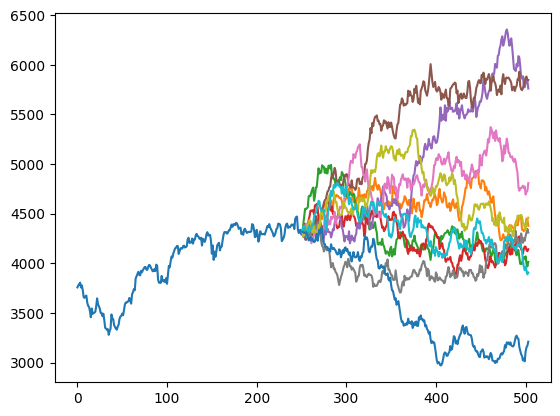

In [13]:
plot1 = pd.Series(history_data, index=np.arange(len(history_data)))
plt.plot(plot1)
for i in range(len(sim_S)):
    plot2 = pd.Series(sim_S[i], index=np.arange(len(history_data)-1, len(history_data)-1+len(sim_S[0])))
    plt.plot(plot2)
plt.show()

### Payoff Function

In [14]:
def payoff(Spath, initial=3487.05, V=1743.525, parti=1.5, denom=1000):
    m = len(Spath)
    Smin = min(Spath)
    if Smin > V:
        payoff = max(denom, denom*(1+parti*(Spath[m-1]/initial-1)))
    else:
        payoff = denom*(Spath[m-1]/initial)
    return payoff

# Risk-Neutral Valuation

In [15]:
ir = pd.read_csv("euro_area_1_year_yield_curve.csv").rename(columns={"DATE": "Date", "TIME PERIOD": "Date String", "Yield curve spot rate, 1-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y)": "Interest Rate"})
ir

,Date,Date String,Interest Rate
0,2004-09-06,06 Sep 2004,2.298838
1,2004-09-07,07 Sep 2004,2.328891
2,2004-09-08,08 Sep 2004,2.346666
3,2004-09-09,09 Sep 2004,2.308988
4,2004-09-10,10 Sep 2004,2.271566
...,...,...,...
4897,2023-10-27,27 Oct 2023,3.420809
4898,2023-10-30,30 Oct 2023,3.406159
4899,2023-10-31,31 Oct 2023,3.387519
4900,2023-11-01,01 Nov 2023,3.376730


In [16]:
r = ir[ir['Date'] == '2023-08-09']['Interest Rate'].values[0] / 100
v = r - sigma**2 / 2
St = history_data[-1]
Nsim=100000
T = 485/252
print(f"r: {r}")
print(f"v: {v}")

r: 0.033256009999999996
v: 0.01866808783453991


In [17]:
# ir = pd.read_csv("Dataset/daily-treasury-rates_1NOV.csv")

In [18]:
# r = ir[ir['Date']=='08/09/2023']['1 Yr'].values[0]/100
# v = r-sigma**2/2
# St = history_data[-1]
# Nsim=100000
# T = 485/252
# print(f"r: {r}")
# print(f"v: {v}")

### Normal Monte Carlo Simulation

In [19]:
# sim_S = simGBMExact(Nsim, St, v, sigma, dt, T)
sim_S = simulate_gbm_exact(Nsim, St, v, sigma, dt, T)

100%|██████████████████████████████████| 100000/100000 [02:29<00:00, 670.40it/s]


#### Plot 50 random simulated path

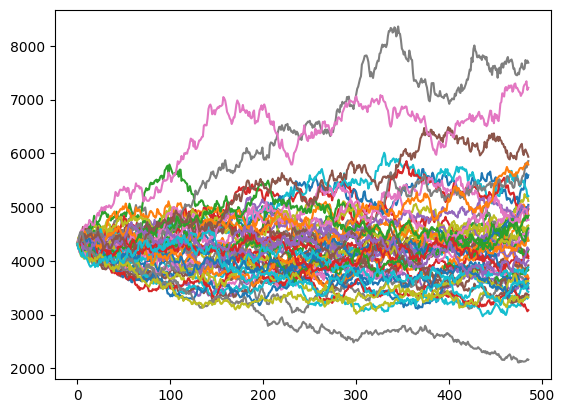

In [20]:
for i in range(len(sim_S[50:100])):
    plot3 = pd.Series(sim_S[i])
    plt.plot(plot3)
plt.show()

In [21]:
sim_S_df = pd.DataFrame(sim_S)

In [22]:
sim_Note = np.exp(-r*T)*sim_S_df.apply(payoff, axis=1)
note_MC = np.mean(sim_Note)
note_MC_var = np.var(sim_Note)/Nsim
lower_percentile = note_MC-1.96*np.sqrt(note_MC_var)
higher_percentile = note_MC+1.96*np.sqrt(note_MC_var)

In [23]:
print(f"Note Value (MC): {note_MC}")
print(f"Estimate Variance: {note_MC_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (MC): 1410.0373892025395
Estimate Variance: 1.7248551635529044
95% Confidence Interval: [1407.463247870696, 1412.611530534383]


### Antithetic Variate Simulation

In [27]:
def simulate_gbm_exact_av(n_sim, S_0, v, sigma, delta_t, T, collate=False):
    '''
    GBM simulation using Monte Carlo with antithetic variates

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    - collate - Boolean: True - Returns [S_t[0], S_tilde_t[0], ..., S_t[n_sim-1], S_tilde_t[n_sim-1]],
                         False - Returns [S_t[0], ..., S_t[n_sim-1], S_tilde_t[0], ..., S_tilde_t[n_sim-1]],
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    S_tilde_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))
    
    for i in tqdm(range(n_sim)):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            # S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))

    if collate:
        collated = [None] * (2*n_sim)
        for i in range(n_sim):
            collated[2*i] = S_t[i]
            collated[2*i+1] = S_tilde_t[i]
        return collated
    S_t = np.append(S_t, S_tilde_t, 0)
    return S_t

In [28]:
# def simGBMExactAV(Nsim, S0, v, sigma, dt, T, collate=False):
#     m=int(T/dt)
#     S = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
#     Stilde = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
#     for i in tqdm(range(Nsim)):
#         Z = np.random.normal(size=m)
#         for j in range(1, m+1):
#             S[i][j] = S[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z[j-1])
#             Stilde[i][j] = Stilde[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*(-Z[j-1]))
#     if collate:
#         output = []
#         for i in range(Nsim):
#             output.append(S[i])
#             output.append(S[i])
#         return output
#     else:
#         return S+Stilde

In [29]:
sim_S_AV = simulate_gbm_exact_av(int(Nsim/2), St, v, sigma, dt, T)
sim_S_AV_df = pd.DataFrame(sim_S_AV)

100%|████████████████████████████████████| 50000/50000 [02:34<00:00, 323.51it/s]


In [30]:
# sim_S_AV = simGBMExactAV(int(Nsim/2), St, v, sigma, dt, T, collate=False)
# sim_S_AV_df = pd.DataFrame(sim_S_AV)

In [31]:
sim_Note_AV = np.exp(-r*T)*sim_S_AV_df.apply(payoff, axis=1)
note_AV = np.mean(sim_Note_AV)
note_AV_var = np.var(sim_Note_AV)/Nsim
lower_percentile = note_AV-1.96*np.sqrt(note_AV_var)
higher_percentile = note_AV+1.96*np.sqrt(note_AV_var)

In [32]:
print(f"Note Value (AV): {note_AV}")
print(f"Estimate Variance: {note_AV_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (AV): 1411.15161052577
Estimate Variance: 1.73243178501633
95% Confidence Interval: [1408.5718217853264, 1413.7313992662134]


### Control Variate Simulation

In [45]:
def simulate_gbm_exact_cv(n_sim, S_0, v, sigma, delta_t, T, payoff_fn, n1=1000):
    hsi_simulations_pre = simulate_gbm_exact(n1, S_0, v, sigma, delta_t, T)
    payoffs_pre = np.array([payoff_fn(sim) for sim in hsi_simulations_pre])
    sim_notes_pre = np.exp(-r * T) * payoffs_pre
    c = -np.cov(sim_notes_pre, hsi_simulations_pre[:,-1])[0,1] / (S_0**2 * np.exp(2*r*T) * (np.exp(sigma**2*T)-1))
    
    hsi_simulations_cv = simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T)
    payoffs_cv = np.array([payoff_fn(sim) for sim in hsi_simulations_cv])
    sim_notes_cv = np.exp(-r * T) * payoffs_cv + c*(hsi_simulations_cv[:,-1] - S_0*np.exp(r*T))
    return sim_notes_cv

In [46]:
# def simGBMExactCV(Nsim, S0, v, sigma, dt, T):
#     small_n = 1000
#     sim_S_pre = simGBMExact(small_n, S0, v, sigma, dt, T)
#     sim_S_pre_df = pd.DataFrame(sim_S_pre)
#     sim_Note_pre = np.exp(-r*T)*sim_S_pre_df.apply(payoff, axis=1)
#     c = -np.cov(sim_Note_pre, [sub[len(sim_S_pre[0])-1] for sub in sim_S_pre])[0][1]/(S0**2*np.exp(2*r*T)*(np.exp(sigma**2*T)-1))
#     print(f"c: {c}")
    
#     sim_S_CV = simGBMExact(Nsim, S0, v, sigma, dt, T)
#     sim_S_CV_df = pd.DataFrame(sim_S_CV)
#     X = np.exp(-r*T)*sim_S_CV_df.apply(payoff, axis=1)
#     sim_note_CV = X + c*([sub[len(sim_S_CV[0])-1] for sub in sim_S_CV]-S0*np.exp(r*T))
#     return sim_note_CV

In [47]:
sim_Note_CV = simulate_gbm_exact_cv(Nsim, St, v, sigma, dt, T, payoff_fn=payoff)

100%|██████████████████████████████████| 100000/100000 [02:24<00:00, 693.04it/s]


In [48]:
# sim_Note_CV = simGBMExactCV(Nsim, St, v, sigma, dt, T)

In [49]:
note_CV = np.mean(sim_Note_CV)
note_CV_var = np.var(sim_Note_CV)/Nsim
lower_percentile = note_CV-1.96*np.sqrt(note_CV_var)
higher_percentile = note_CV+1.96*np.sqrt(note_CV_var)

In [50]:
print(f"Note Value (CV): {note_CV}")
print(f"Estimate Variance: {note_CV_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (CV): 1410.395961132243
Estimate Variance: 0.040207184885147955
95% Confidence Interval: [1410.002947237508, 1410.788975026978]


### Stratified Sampling Simulation

In [51]:
def simulate_gbm_1_shoot_ss(n_strata, n_sim_s, S_0, v, sigma, T):
    '''
    GBM simulation using Monte Carlo with stratified sampling

    Takes in the following parameters:
    - n_strata (integer): No. of strata
    - n_sim_s (integer): No. of simulations to generate per strata (Total = n_strata * n_sim_s)
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - T (float): End date, used to calculate no. of periods
    '''
    V = np.random.uniform(size=n_sim_s) / n_strata
    for i in range(1, n_strata):
        V = np.append(V, (i + np.random.uniform(size=n_sim_s)) / n_strata, 0 )
    Z = np.array(scipy.stats.norm.ppf(V))
    S_T = S_0 * np.exp(v*T + sigma*np.sqrt(T)*Z)
    # S_T = S_0 * np.exp(v*T - 0.5*(sigma**2)*T + sigma*np.sqrt(T)*Z)
    return S_T.reshape(n_sim_s*n_strata, 1)

In [52]:
# def simGBMExactSS(stratraNo, Nsim, S0, v, sigma, dt, T):
#     N=int(Nsim/stratraNo)
#     m=int(T/dt)

#     S = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
#     for i in tqdm(range(stratraNo)):
#         for j in tqdm(range(N)):
#             V = (np.random.uniform(size=m)+i)/stratraNo
#             Z = scipy.stats.norm.ppf(V)
#             for k in range(1, m+1):
#                 S[j+i*N][k] = S[j+i*N][k]*np.exp(v*dt+sigma*np.sqrt(dt)*Z[k-1])
#     return S

In [58]:
n_strata = 5
n_sim_s = Nsim // n_strata
sim_S_SS = simulate_gbm_1_shoot_ss(n_strata, n_sim_s, St, v, sigma, T)
sim_S_SS_df = pd.DataFrame(sim_S_SS)

In [59]:
# sim_S_SS = simGBMExactSS(100, Nsim, St, v, sigma, dt, T)
# sim_S_SS_df = pd.DataFrame(sim_S_SS)

In [63]:
sim_Note_SS = np.exp(-r*T)*sim_S_SS_df.apply(payoff, axis=1)
note_SS = np.mean(sim_Note_SS)
note_SS_var = np.var(sim_Note_SS)/Nsim
lower_percentile = note_SS-1.96*np.sqrt(note_SS_var)
higher_percentile = note_SS+1.96*np.sqrt(note_SS_var)

In [64]:
print(f"Note Value (SS): {note_SS}")
print(f"Estimate Variance: {note_SS_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (SS): 1411.342093220231
Estimate Variance: 1.737996785348478
95% Confidence Interval: [1408.7581643414508, 1413.926022099011]


### Empirical Martingale Simulation

In [65]:
def simulate_gbm_ems(sim_paths, delta_t, r):
    '''
    GBM simulation using Empirical Martingale Simulation

    Takes in the following parameters:
    - sim_paths (np.array): List of paths generated from `simulate_gbm_exact`, shape: (n_sim, n_periods+1)
    - delta_t (float): Value of one timestep (e.g. 1/252, 1 day out of 252 working days in a year)
    - r (float): Risk-free interest rate
    '''
    n_sim = sim_paths.shape[0]
    n_periods = sim_paths.shape[1] - 1
    S = np.zeros((n_sim, n_periods+1))
    Z = np.zeros((n_sim+1, n_periods))
    S[:, 0] = sim_paths[:, 0]

    for j in range(1, n_periods+1):
        Z[:n_sim, j-1] = S[:,j-1]*sim_paths[:, j] / sim_paths[:, j-1]
        Z[n_sim,j-1] = np.exp(-r*((j-1)*delta_t)) * np.mean(Z[:n_sim,j-1])
        S[:,j] = sim_paths[:, 0] * Z[:n_sim, j-1] / Z[n_sim, j-1]
    return S

In [66]:
sim_S_EMS = simulate_gbm_ems(sim_S, dt, r)
sim_S_EMS_df = pd.DataFrame(sim_S_SS)

In [67]:
sim_Note_EMS = np.exp(-r*T)*sim_S_EMS_df.apply(payoff, axis=1)
note_EMS = np.mean(sim_Note_EMS)
note_EMS_var = np.var(sim_Note_EMS)/Nsim
lower_percentile = note_EMS-1.96*np.sqrt(note_EMS_var)
higher_percentile = note_EMS+1.96*np.sqrt(note_EMS_var)

In [68]:
print(f"Note Value (EMS): {note_EMS}")
print(f"Estimate Variance: {note_EMS_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (EMS): 1411.342093220231
Estimate Variance: 1.737996785348478
95% Confidence Interval: [1408.7581643414508, 1413.926022099011]
